# DSE230: Programming Assignment 5 - XGBoost using SageMaker 

## Classification on Amazon SageMaker

Perform a classification task on the given dataset.<br>
Using the features given, you will train a XGBoost decision tree model to predict a given person's salary (the `WAGP` column) - which will be categorized into multiple bins.<br>

--- 

#### Tasks: 

- Perform Exploratory Data Analysis on the given dataset
- Save preprocessed datasets to Amazon S3
- Use the Amazon Sagemaker platform to train an XGBoost model
- Evaluate the model on the test set
- Perform hyperparameter tuning on the XGBoost model
- Submit
  - Submit this Jupyter Notebook (`.ipynb`) to "PA5"
  - Screenshot of SageMaker dashboard showing no running jobs (nothing should be in green).
  - Make sure all the cell outputs are present in the notebook
  - You can put both the `.ipynb` and the screenshot in a `.zip` file for submission.
  
#### Due date: Thursday 6/10/2021 at 11:59 PM PST

---

Remember: when in doubt, read the documentation first. It's always helpful to search for the class that you're trying to work with, e.g. pyspark.sql.DataFrame. 

Pandas API documentation: https://pandas.pydata.org/pandas-docs/stable/reference/index.html

Amazon Sagemaker API documentation: https://sagemaker.readthedocs.io/en/stable/

Amazon Sagemaker Tutorials: https://docs.aws.amazon.com/sagemaker/latest/dg/gs.html 

---

### 1. Import packages and Get Amazon IAM execution role & instance region

In [1]:
import os, sagemaker
from sagemaker import get_execution_role
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

Make sure to create an S3 bucket or re-use the ones from prior exercises

In [2]:
# Define IAM role- this will be necessary when defining your model
iam_role = get_execution_role()

# Set SageMaker session handle
sess = sagemaker.Session()

# set the region of the instance and get a reference to the client
region = sess.boto_session.region_name

bucket = 'pa5bucket'

print('Using bucket ' + bucket)
print("Success - the SageMaker instance is in the " + region + " region")

Using bucket pa5bucket
Success - the SageMaker instance is in the us-west-2 region


### 2. Read data.

NOTE - Upload the data to your S3 bucket before this step. Make sure it is in `.csv` format

In [3]:
import pandas as pd
import pickle

prefix = "data"

# Read data from the S3 bucket
file_path = "s3://{}/{}/{}".format(bucket, prefix ,"person_records_merged.csv")

df = pd.read_csv(file_path)
df.head()

,SERIALNO,SPORDER,PUMA,ST,ADJINC,AGEP,CIT,CITWP,COW,DDRS,...,RACWHT,RC,SFN,SFR,SOCP,VPS,WAOB,FHINS3C,FHINS4C,FHINS5C
0,84,1,2600,1,1007549,19,1,NaN,NaN,2.0,...,1,0,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
1,154,1,2500,1,1007549,55,1,NaN,1.0,2.0,...,0,0,NaN,NaN,411011,NaN,1,NaN,NaN,NaN
2,154,2,2500,1,1007549,56,1,NaN,6.0,2.0,...,0,0,NaN,NaN,493050,NaN,1,NaN,NaN,NaN
3,154,3,2500,1,1007549,21,1,NaN,NaN,2.0,...,0,0,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
4,154,4,2500,1,1007549,21,1,NaN,NaN,1.0,...,0,0,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN


### Description of Columns

There are lots of columns in the original dataset. However, we'll only use the following columns whose descriptions are given below.


AGEP -  Age

COW - Class of worker

WAGP - Wages or salary income past 12 months

JWMNP - Travel time to work

JWTR - Means of transportation to work

MAR - Marital status

PERNP - Total person's earnings

NWAV - Available for work

NWLA - On layoff from work

NWLK - Looking for work

NWAB - Temporary absence from work

SCHL - Educational attainment

WKW - Weeks worked during past 12 months

Task:
* Select the given column names below.

In [4]:
colNames = ['AGEP', 'COW', 'WAGP', 'JWMNP', 'JWTR', 'MAR', 'PERNP', 'NWAV', 
            'NWLA', 'NWLK', 'NWAB', 'SCHL', 'WKW']

df = df[colNames]
df.head()

,AGEP,COW,WAGP,JWMNP,JWTR,MAR,PERNP,NWAV,NWLA,NWLK,NWAB,SCHL,WKW
0,19,NaN,0.0,NaN,NaN,5,0.0,5.0,2.0,2.0,2.0,19.0,NaN
1,55,1.0,52000.0,30.0,1.0,1,52000.0,5.0,3.0,3.0,3.0,20.0,1.0
2,56,6.0,0.0,NaN,11.0,1,99000.0,5.0,3.0,3.0,3.0,16.0,1.0
3,21,NaN,0.0,NaN,NaN,5,0.0,5.0,2.0,2.0,2.0,19.0,NaN
4,21,NaN,0.0,NaN,NaN,5,0.0,5.0,2.0,2.0,2.0,19.0,NaN


### 3. Filtering data

Find the correlation of the WAGP value with all other features.
You can use the following technique for finding correlation between two columns:

`df['col_1'].corr(df['col_2'])` gives you the correlation between col_1 and col_2.

Your task is to find the correlation between WAGP and all other columns.

In [5]:
print(df['WAGP'].corr(df['AGEP']))
print(df['WAGP'].corr(df['COW']))
print(df['WAGP'].corr(df['JWMNP']))
print(df['WAGP'].corr(df['JWTR']))
print(df['WAGP'].corr(df['MAR']))
print(df['WAGP'].corr(df['PERNP']))
print(df['WAGP'].corr(df['NWAV']))
print(df['WAGP'].corr(df['NWLA']))
print(df['WAGP'].corr(df['NWLK']))
print(df['WAGP'].corr(df['NWAB']))
print(df['WAGP'].corr(df['SCHL']))
print(df['WAGP'].corr(df['WKW']))

-0.034028422159155094
-0.06277891444051938
0.10563870072567638
-0.02663101226571325
-0.16781655340177995
0.9507294493107374
0.11007110010819084
0.33443922964541806
0.3253553252937494
0.32382211459316546
0.2919666973089092
-0.3039528417971144


From the results of the above cell, you should see that `PERNP` is highly correlated with `WAGP`.
Since `PERNP` is highly correlated with `WAGP` remove that column from the dataset.

In [6]:
colNames = ['AGEP', 'COW', 'WAGP', 'JWMNP', 'JWTR', 'MAR', 'NWAV', 'NWLA', 'NWLK', 'NWAB', 'SCHL', 'WKW']

df = df[colNames]
df.head()

,AGEP,COW,WAGP,JWMNP,JWTR,MAR,NWAV,NWLA,NWLK,NWAB,SCHL,WKW
0,19,NaN,0.0,NaN,NaN,5,5.0,2.0,2.0,2.0,19.0,NaN
1,55,1.0,52000.0,30.0,1.0,1,5.0,3.0,3.0,3.0,20.0,1.0
2,56,6.0,0.0,NaN,11.0,1,5.0,3.0,3.0,3.0,16.0,1.0
3,21,NaN,0.0,NaN,NaN,5,5.0,2.0,2.0,2.0,19.0,NaN
4,21,NaN,0.0,NaN,NaN,5,5.0,2.0,2.0,2.0,19.0,NaN


See the statistics of the target variable. Use the `.describe()` method to see the statistics of the WAGP column.

In [7]:
df.describe()

,AGEP,COW,WAGP,JWMNP,JWTR,MAR,NWAV,NWLA,NWLK,NWAB,SCHL,WKW
count,3.132795e+06,1.844222e+06,2.582042e+06,1.316972e+06,1.381863e+06,3.132795e+06,2.541519e+06,2.541519e+06,2.541519e+06,2.541519e+06,3.035514e+06,1.590864e+06
mean,4.045884e+01,2.166637e+00,2.565256e+04,2.602648e+01,1.998278e+00,2.947562e+00,4.664924e+00,2.556265e+00,2.537082e+00,2.578273e+00,1.582702e+01,1.929787e+00
std,2.347346e+01,1.951042e+00,4.736001e+04,2.235223e+01,2.817300e+00,1.853487e+00,1.037828e+00,5.205866e-01,5.942344e-01,5.199191e-01,5.677245e+00,1.655226e+00
min,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,2.000000e+01,1.000000e+00,0.000000e+00,1.000000e+01,1.000000e+00,1.000000e+00,5.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,1.400000e+01,1.000000e+00
50%,4.100000e+01,1.000000e+00,6.000000e+03,2.000000e+01,1.000000e+00,3.000000e+00,5.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,1.700000e+01,1.000000e+00
75%,5.900000e+01,3.000000e+00,3.600000e+04,3.000000e+01,1.000000e+00,5.000000e+00,5.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,2.000000e+01,3.000000e+00
max,9.500000e+01,9.000000e+00,6.600000e+05,1.670000e+02,1.200000e+01,5.000000e+00,5.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,2.400000e+01,6.000000e+00


### 4. Outlier Removal

Remove outlier rows based on values in the `WAGP` column. This will be an important step that impacts our model's predictive performance in the classification step below.

Based on the statistics above, we need an **upper limit** to filter out significant outliers.
We'll filter out all the data points for which WAGP is more than the mean + 3 standard deviations.

Your tasks:
1. Filter the dataframe using a calculated upper limit for WAGP

Expected Output:
1. Number of outlier rows removed from DataFrame

Instructions:
* Find the mean ($\mu$) and standard deviation($\sigma$) of the column `WAGP`
* Set `upperLimit` to 3 standard deviations from the mean i.e. $upperLimit = \mu + 3 \sigma$
* Filter the dataframe so that values in `WAGP` column are less than the upper limit i.e. `df['WAGP'] < upperLimit`
* Print the difference in length of original dataframe and the filtered dataframe
* For the following tasks after this step, you will use the filtered dataframe

In [8]:
u = df['WAGP'].mean()
o = df['WAGP'].std()

upperLimit = u + 3*o
df_filtered = df[df['WAGP'] < upperLimit]

print('Length of original dataframe:', df.shape[0])
print('\nLength of filtered dataframe:', df_filtered.shape[0])

Length of original dataframe: 3132795

Length of filtered dataframe: 2544480


### 5. Dropping NAs

Drop rows with any nulls in any of the columns.<br>
Print the resulting DataFrame's row count.

**Note**: The more features you choose, the more rows with nulls you will drop. This may be desirable if you are running into memory problems<br>

Your tasks:
1. Drop rows with any nulls

Expected Output: 
1. Number of rows in cleaned DataFrame

In [9]:
df_cleaned = df_filtered.dropna()
print('Number of rows in cleaned DataFrame:', df_cleaned.shape[0])

Number of rows in cleaned DataFrame: 1282781


### 6. Discretize salary

We want to convert the WAGP column, which contains continuous values, into a column with discrete labels so that we can use it as the label column for our classification problem. 
We're essentially turning a regression problem into a classification problem. Instead of predicting a person's exact salary, we're predicting the range in which that person's salary lies.

Note that labels are integers and should start from 0. 

XGBoost expects that the Label column (WAGP_CAT) is the first column in the dataset.

Your tasks:
1. Make a new column for discretized labels with 5 bins. Recommended column name is `WAGP_CAT`
    - XGBoost expects that the Label column (WAGP_CAT) is the first column in the dataset.
    - Remember to put your label column as the first column in the dataframe, otherwise training won't run!
2. Examine the label column - plot a histogram of the `WAGP_CAT` column values

Expected Output: 
1. The first 5 rows of the dataframe with the discretized label column. The label column must be the first column in the dataframe. 
2. A histogram from the discretized label column

* Categorize the labels into multiple bins - 5 bins in this case
* Look up the pd.cut() function to see how the WAGP column is converted to different bins

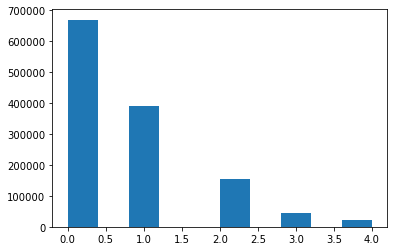

,AGEP,COW,WAGP,JWMNP,JWTR,MAR,NWAV,NWLA,NWLK,NWAB,SCHL,WKW,WAGP_CAT
1,55,1.0,52000.0,30.0,1.0,1,5.0,3.0,3.0,3.0,20.0,1.0,1
5,63,3.0,39000.0,15.0,1.0,3,5.0,3.0,3.0,3.0,21.0,1.0,1
11,59,1.0,90000.0,10.0,1.0,1,1.0,2.0,2.0,2.0,16.0,1.0,2
12,56,1.0,46000.0,45.0,1.0,1,5.0,3.0,3.0,3.0,18.0,1.0,1
16,72,4.0,20000.0,5.0,1.0,1,5.0,3.0,3.0,3.0,21.0,1.0,0


In [10]:
import matplotlib.pyplot as plt

df_cleaned['WAGP_CAT'] = pd.cut(df_cleaned['WAGP'], bins=5, labels=[0,1,2,3,4])

# Plot a histogram of the WAGP_CAT column
plt.hist(df_cleaned['WAGP_CAT'])
plt.show()

df_cleaned.head(5)

Rearranging the colums so that the WAGP_CAT column is the first column and drop WAGP (will make problem trivial otherwise). XGBoost expects labels to be in the first column. The code has been given for you

In [11]:
cols = df_cleaned.columns.tolist()
df_cleaned = df_cleaned[cols[-1:] + cols[:-1]].drop('WAGP', axis=1)
df_cleaned.head()

,WAGP_CAT,AGEP,COW,JWMNP,JWTR,MAR,NWAV,NWLA,NWLK,NWAB,SCHL,WKW
1,1,55,1.0,30.0,1.0,1,5.0,3.0,3.0,3.0,20.0,1.0
5,1,63,3.0,15.0,1.0,3,5.0,3.0,3.0,3.0,21.0,1.0
11,2,59,1.0,10.0,1.0,1,1.0,2.0,2.0,2.0,16.0,1.0
12,1,56,1.0,45.0,1.0,1,5.0,3.0,3.0,3.0,18.0,1.0
16,0,72,4.0,5.0,1.0,1,5.0,3.0,3.0,3.0,21.0,1.0


### 7. Splitting data and converting to CSV

 Split the dataset into train, validation, and test sets using sklearn's train_test_split. 
Look up the API definition of train_test_split to see what values you need to pass.
First, we'll split the df_cleaned2 dataframe into two parts - `train_data` and `val_data` with an 80:20 ratio, and then
we'll split the `train_data` into `train_data` and `test_data` in a 90:10 ratio.

Use the following parameters for train_test_split:
* `random_state = 42`
* `shuffle = True`
* `train_size = 0.8`, `test_size = 0.2` for the first split
* `train_size = 0.9`, `test_size = 0.1` for the second split

In [12]:
train_data, val_data = train_test_split(df_cleaned, test_size=0.2, random_state = 42, shuffle = True)

train_data, test_data = train_test_split(train_data, test_size=0.1, random_state = 42, shuffle = True, )

len(train_data), len(val_data), len(test_data)

(923601, 256557, 102623)

### Write prepared data to files.
Refer to the demo to write the train_data, val_data, and test_data to csv files using the `.to_csv()` method
Use `index = False` and `header = False` as the parameters.

In [13]:
# Write prepared data to files

train_data.to_csv('train_data.csv', index=False, header=False)
val_data.to_csv('val_data.csv', index=False, header=False)
test_data.to_csv('test_data.csv', index=False, header=False)

### 8. Save processed data to S3

This step is needed for using XGBoost with Amazon Sagemaker. Send data to S3. SageMaker will read training data from S3.

In [14]:
prefix = "data"
key_prefix = prefix + "/model_data"

trainpath = sess.upload_data(
    path='train_data.csv', bucket=bucket,
    key_prefix=key_prefix)

valpath = sess.upload_data(
    path='val_data.csv', bucket=bucket,
    key_prefix=key_prefix)

testpath = sess.upload_data(
    path='test_data.csv', bucket=bucket,
    key_prefix=key_prefix)

In [15]:
trainpath, valpath, testpath

('s3://pa5bucket/data/model_data/train_data.csv',
 's3://pa5bucket/data/model_data/val_data.csv',
 's3://pa5bucket/data/model_data/test_data.csv')

## 9. Create channels for train and validation data to feed to model
Set up data channels for the training, validation, and test data as shown in the demo.
You'll have to use the TrainingInput function and pass the s3_data and content_type parameters.

In [16]:
# Set data channels

s3_input_train = sagemaker.inputs.TrainingInput(s3_data=trainpath, content_type='csv')
s3_input_val = sagemaker.inputs.TrainingInput(s3_data=valpath, content_type='csv')
s3_input_test = sagemaker.inputs.TrainingInput(s3_data=testpath, content_type='csv')

Set model output location as shown in the demo.

In [17]:
output_location = "s3://{}/{}/model".format(bucket, prefix)
print('Training artifacts will be uploaded to: {}'.format(output_location))

Training artifacts will be uploaded to: s3://pa5bucket/data/model


### 10. Create the XGBoost model
We'll create the XGBoost model, and set its hyperparameters.

In [18]:
from sagemaker.amazon.amazon_estimator import image_uris
xgb_image = image_uris.retrieve(framework="xgboost", region=region, version='latest')

### Create an Estimator using sagemaker.estimator.Estimator.
You'll need to pass the xgb_image and the iam_role parameters.

Use the following values for other parameters:
* `instance_count = 1`
* `instance_type = ml.m5.xlarge`
* `output_path = output_location`
* `sagemaker_session = sess`

In [19]:
xgb = sagemaker.estimator.Estimator(xgb_image,
                                      iam_role, 
                                      instance_count=1, 
                                      instance_type='ml.m5.xlarge',
                                      output_path=output_location,
                                      sagemaker_session=sess)

### 11. Set model hyperparameters
Set the hyperparameters for the model. You'll have to use the `set_hyperparameters()` method.
Refer to the demo for how it's done.

Read the below references for more information:
https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html
https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst#learning-task-parameters

Use the following values for the parameters:
* `num_class = 5`
* `max_depth = 2`
* `min_child_weight = 2`
* `early_stopping_rounds=5`
* `objective='multi:softmax'`
* `num_round=100`

In [20]:
xgb.set_hyperparameters(num_class = 5,
                          max_depth = 2, 
                          min_child_weight = 2,
                          early_stopping_rounds=5,
                          objective = "multi:softmax",          
                          num_round = 100)

### 12. Train model using train and validation data channels
Use the `.fit()` method to fit the model using the training and validation data channels. 
Execute the XGBoost training job.

NOTE:  This step may take several minutes

In [21]:
%%time

# Fit model using  data channels
xgb.fit({'train': s3_input_train, 'validation': s3_input_val})

2021-06-08 15:17:34 Starting - Starting the training job...
2021-06-08 15:17:58 Starting - Launching requested ML instancesProfilerReport-1623165454: InProgress
......
2021-06-08 15:18:58 Starting - Preparing the instances for training......
2021-06-08 15:19:59 Downloading - Downloading input data...
2021-06-08 15:20:27 Training - Training image download completed. Training in progress..Arguments: train
[2021-06-08:15:20:28:INFO] Running standalone xgboost training.
[2021-06-08:15:20:28:INFO] File size need to be processed in the node: 50.53mb. Available memory size in the node: 7891.74mb
[2021-06-08:15:20:28:INFO] Determined delimiter of CSV input is ','
[15:20:28] S3DistributionType set as FullyReplicated
[15:20:28] 923601x11 matrix with 10159611 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-06-08:15:20:28:INFO] Determined delimiter of CSV input is ','
[15:20:28] S3DistributionType set as FullyReplicated
[15:20:28] 256557x11 matrix with 2822

### 13. Deploying model
Deploy the model so that it can be used for inference.

Use the .deploy() method to deploy your model.

Use the following values for the parameters:

* `initial_instance_count = 1`
* `instance_type = 'ml.t2.medium'`
* `serializer = sagemaker.serializers.CSVSerializer()`

NOTE:  This step may take several minutes

In [22]:
%%time

xgb_predictor = xgb.deploy(initial_instance_count=1,
                             serializer = sagemaker.serializers.CSVSerializer(),
                             instance_type='ml.t2.medium')

-------------!CPU times: user 237 ms, sys: 6.93 ms, total: 244 ms
Wall time: 6min 31s


### 14. Testing the model on test data

* Store the values in `WAGP_CAT` column of test_data in `y_true` variable
* Drop `WAGP_CAT` column from the test_data. Convert the resulting dataframe to an array using `.values`
* Use the deployed model(from the previous step) to get the predictions on the test data
* Store the value of predictions in `y_pred`

In [23]:
# Store the values in WAGP_CAT column of test_data in y_true variable
y_true = test_data['WAGP_CAT'].values

# Drop WAGP_CAT column from the test_data. Convert the resulting dataframe to an array using .values
test_data_array = test_data.drop(['WAGP_CAT'], axis=1).values

predictions = xgb_predictor.predict(data=test_data_array).decode('utf-8') 
predictions_array = np.fromstring(predictions, sep=',')  

# Store the value of predictions in y_pred
y_pred = predictions_array.astype(int)

print(y_pred)
print(y_true)

print("Accuracy : %.5f" %  accuracy_score(y_true,y_pred))

[0 0 1 ... 0 0 0]
[0, 0, 1, 0, 0, ..., 2, 0, 1, 1, 0]
Length: 102623
Categories (5, int64): [0 < 1 < 2 < 3 < 4]
Accuracy : 0.60784


### 15. Confusion matrix and classification report

Use the `confusion_matrix` and the `classification_report` methods to see how your model performs on the test set.

In [24]:
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[43384  9663   457     0     1]
 [12782 17513   995     0     0]
 [ 2674  8204  1477     5     2]
 [  495  2277   904     4     1]
 [  213   940   621    11     0]]
              precision    recall  f1-score   support

           0       0.73      0.81      0.77     53505
           1       0.45      0.56      0.50     31290
           2       0.33      0.12      0.18     12362
           3       0.20      0.00      0.00      3681
           4       0.00      0.00      0.00      1785

    accuracy                           0.61    102623
   macro avg       0.34      0.30      0.29    102623
weighted avg       0.57      0.61      0.57    102623



### IMPORTANT: DELETE THE ENDPOINT

Delete the endpoint once it has served its purpose.

In [25]:
xgb_predictor.delete_endpoint()

### 16. Hyperparameter tuning

Read through the following links for more information:
https://sagemaker.readthedocs.io/en/stable/api/training/tuner.html
https://aws.amazon.com/blogs/machine-learning/amazon-sagemaker-automatic-model-tuning-now-supports-random-search-and-hyperparameter-scaling/

We'll use do hyperparameter tuning on two hyperparameters:

1. min_child_weight
2. max_depth

We'll use a `Random` search strategy since that's more effective than searching all possible combinations of hyperparameters. The code has been given for you.

In [26]:
from sagemaker.tuner import HyperparameterTuner, IntegerParameter

# Define exploration boundaries
hyperparameter_ranges = {
    'min_child_weight': IntegerParameter(1, 10),
    'max_depth': IntegerParameter(1, 10)
}

# create Optimizer
Optimizer = HyperparameterTuner(
    estimator=xgb,
    hyperparameter_ranges=hyperparameter_ranges,
    base_tuning_job_name='XGBoost-Tuner',
    objective_type='Minimize',
    objective_metric_name='validation:merror',
    max_jobs=5,
    max_parallel_jobs=5,
    strategy='Random')

Now that we have created the Optimizer. We need to call `.fit()` on it to start the tuning job.

Refer to the demo and see how to call `fit()` and pass the appropriate data channels.

In [27]:
%%time

# Launch tuning job
Optimizer.fit({'train': s3_input_train, 'validation': s3_input_val})

....................................................................!
CPU times: user 360 ms, sys: 28.5 ms, total: 388 ms
Wall time: 5min 44s


### 17. Results of tuning job

Get the tuner results in a dataframe. The code is given to you for getting the results of the tuning job in a dataframe.

In [28]:
results = Optimizer.analytics().dataframe()
results

,max_depth,min_child_weight,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,7.0,2.0,XGBoost-Tuner-210608-1528-005-b8a7c8f9,Completed,0.386924,2021-06-08 15:31:18+00:00,2021-06-08 15:33:34+00:00,136.0
1,8.0,3.0,XGBoost-Tuner-210608-1528-004-918e1757,Completed,0.387037,2021-06-08 15:31:21+00:00,2021-06-08 15:33:55+00:00,154.0
2,3.0,6.0,XGBoost-Tuner-210608-1528-003-f34bc67e,Completed,0.388623,2021-06-08 15:31:32+00:00,2021-06-08 15:33:52+00:00,140.0
3,7.0,10.0,XGBoost-Tuner-210608-1528-002-ba01b59c,Completed,0.387201,2021-06-08 15:31:30+00:00,2021-06-08 15:33:25+00:00,115.0
4,2.0,10.0,XGBoost-Tuner-210608-1528-001-c7ff9a9f,Completed,0.390401,2021-06-08 15:31:11+00:00,2021-06-08 15:33:28+00:00,137.0


See the best hyperparameters found by the optimizer.

In [29]:
%%time
# Get hyperparameters of tuned model

Optimizer.best_estimator().hyperparameters()


2021-06-08 15:33:34 Starting - Preparing the instances for training
2021-06-08 15:33:34 Downloading - Downloading input data
2021-06-08 15:33:34 Training - Training image download completed. Training in progress.
2021-06-08 15:33:34 Uploading - Uploading generated training model
2021-06-08 15:33:34 Completed - Training job completed
CPU times: user 17.1 ms, sys: 114 µs, total: 17.3 ms
Wall time: 140 ms


{'_tuning_objective_metric': 'validation:merror',
 'early_stopping_rounds': '5',
 'max_depth': '7',
 'min_child_weight': '2',
 'num_class': '5',
 'num_round': '100',
 'objective': 'multi:softmax'}

### 18. Deploy the tuned model.

"Use the .deploy() method to deploy the best model found by the Optimizer.
If you call Optimizer.deploy() method, it will deploy the best model it found.

Use these parameters when calling deploy:
* `initial_instance_count=1`
* `instance_type= 'ml.t2.medium'`
* `serializer = sagemaker.serializers.CSVSerializer()`

Refer to the demo if you are unsure of what to do.

In [30]:
tuned_model_predictor = Optimizer.deploy(initial_instance_count=1,
                    instance_type='ml.t2.medium', serializer = sagemaker.serializers.CSVSerializer())


2021-06-08 15:33:34 Starting - Preparing the instances for training
2021-06-08 15:33:34 Downloading - Downloading input data
2021-06-08 15:33:34 Training - Training image download completed. Training in progress.
2021-06-08 15:33:34 Uploading - Uploading generated training model
2021-06-08 15:33:34 Completed - Training job completed
-----------------!

### 19. Test the tuned model on test data

* Use the deployed model(from the previous step) to get the predictions on the test data
* Store the value of predictions in `y_pred`

In [31]:
# Calculate evaluation metrics
y_true = test_data['WAGP_CAT'].values

# Drop the label column and load data into an array
test_data_array = test_data.drop(['WAGP_CAT'], axis=1).values

predictions_tuned = tuned_model_predictor.predict(data=test_data_array).decode('utf-8') # predict!
predictions_array_tuned = np.fromstring(predictions_tuned, sep=',') # and turn the prediction into an array

y_pred = predictions_array_tuned.astype(int)

print(y_pred)
print(y_true)

print("Accuracy : %.5f" % accuracy_score(y_true,y_pred))

[0 0 1 ... 0 0 0]
[0, 0, 1, 0, 0, ..., 2, 0, 1, 1, 0]
Length: 102623
Categories (5, int64): [0 < 1 < 2 < 3 < 4]
Accuracy : 0.61106


### 20. Confusion matrix and classification report
Use the `confusion_matrix` and the `classification_report` methods to see how your model performs on the test set.

You should see that the tuned model gives you better performance in the f1-score for each (or most) of  the classses. If not, then you're probably doing something wrong.

HINT - Follow instructions similar to section **14. Testing the model on test data**

In [32]:
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.80      0.77     53505
           1       0.46      0.57      0.51     31290
           2       0.35      0.17      0.23     12362
           3       0.36      0.01      0.02      3681
           4       0.33      0.00      0.00      1785

    accuracy                           0.61    102623
   macro avg       0.45      0.31      0.30    102623
weighted avg       0.59      0.61      0.58    102623

[[42879 10076   547     3     0]
 [12068 17724  1493     5     0]
 [ 2443  7827  2068    23     1]
 [  466  2053  1123    36     3]
 [  205   825   719    34     2]]


### IMPORTANT: DELETE THE ENDPOINT


In [33]:
tuned_model_predictor.delete_endpoint()

### 21. Screenshot of everything terminated.

You need to submit a screenshot of terminated endpoints and notebook instances once you are done with the assignment. Nothing should be in green in this screenshot since all running instances are shown in green.

You can take the screenshot of the Dashboard once you go to Amazon SageMaker.